In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

In [2]:
lifecycleOldConfigOldSim <- fread("results.old/lifecycle.csv.gz", stringsAsFactors=TRUE)

In [16]:
lifecycleOldConfigNewSim <- fread("experiments/old-config/lifecycle.csv.gz", stringsAsFactors=TRUE)

In [17]:
lifecycleNewConfigNewSim <- fread("experiments/NA,0.100/lifecycle.csv.gz", stringsAsFactors=TRUE)

In [23]:
lifecycle <-
    rbind(
        lifecycleOldConfigOldSim[, .(`sim-cli`=factor("sim-rs-1.0.0"), `config.yaml`=factor("old config.yaml"), `Kind`, `Item`, `Size [B]`, `References`, `Created [s]`, `To IB [s]`, `To EB [s]`, `To RB [s]`, `In RB [s]`)],
        lifecycleOldConfigNewSim[, .(`sim-cli`=factor("sim-rs-1.1.0"), `config.yaml`=factor("old config.yaml"), `Kind`, `Item`, `Size [B]`, `References`, `Created [s]`, `To IB [s]`, `To EB [s]`, `To RB [s]`, `In RB [s]`)],
        lifecycleNewConfigNewSim[, .(`sim-cli`=factor("sim-rs-1.1.0"), `config.yaml`=factor("new config.yaml"), `Kind`, `Item`, `Size [B]`, `References`, `Created [s]`, `To IB [s]`, `To EB [s]`, `To RB [s]`, `In RB [s]`)]
    )
lifecycle %>% summary

         sim-cli                 config.yaml      Kind        
 sim-rs-1.0.0:1059625   old config.yaml:1119724   EB:    627  
 sim-rs-1.1.0: 120212   new config.yaml:  60113   RB:    627  
                                                  TX:1178583  
                                                              
                                                              
                                                              
                                                              
           Item            Size [B]        References      Created [s]     
 105-node-598:     24   Min.   :   240   Min.   : 0.000   Min.   :  20.07  
 20-node-220 :     24   1st Qu.:  1500   1st Qu.: 2.000   1st Qu.: 285.05  
 26-node-95  :     24   Median :  1500   Median : 2.000   Median : 510.13  
 54-node-525 :     24   Mean   :  1621   Mean   : 2.582   Mean   : 510.10  
 65-node-61  :     24   3rd Qu.:  1500   3rd Qu.: 2.000   3rd Qu.: 735.14  
 66-node-529 :     24   Max.   :256240  

In [24]:
txFirst <- 60
txLast <- 960
txWindow <- txLast - txFirst
simFinish <- 1200

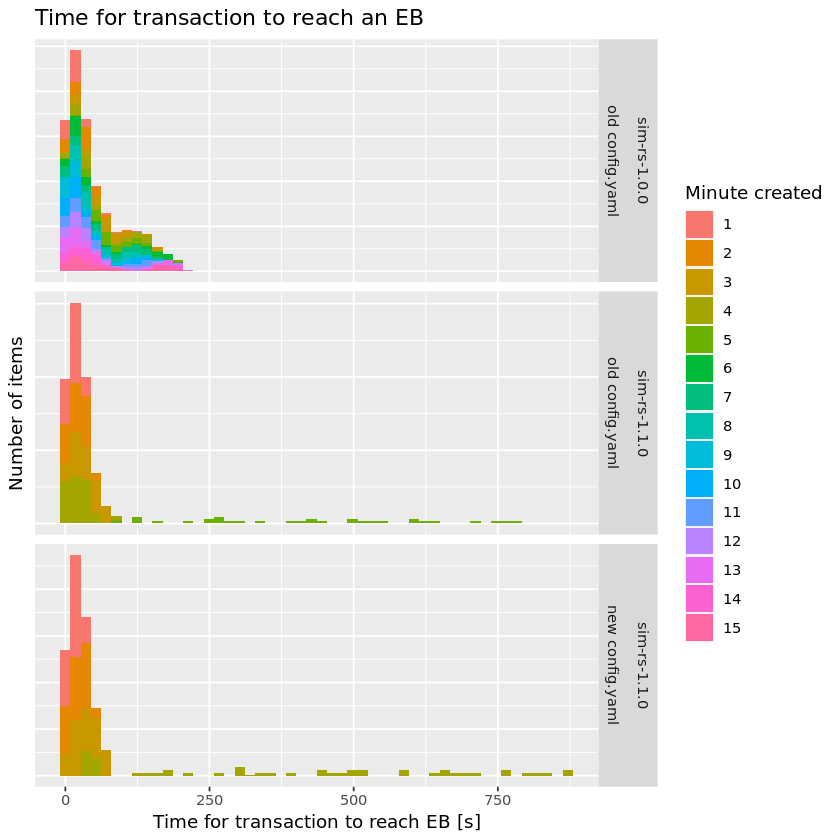

In [25]:
ggplot(
        lifecycle[
            `Kind` == "TX" & 
            !is.na(`To EB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
            .(`sim-cli`, `config.yaml`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
    facet_grid(`sim-cli` + `config.yaml` ~ ., scales="free_y") +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [26]:
ggsave("plots/regression-reach-eb-tx.png", units="in", dpi=150, width=16, height=8)

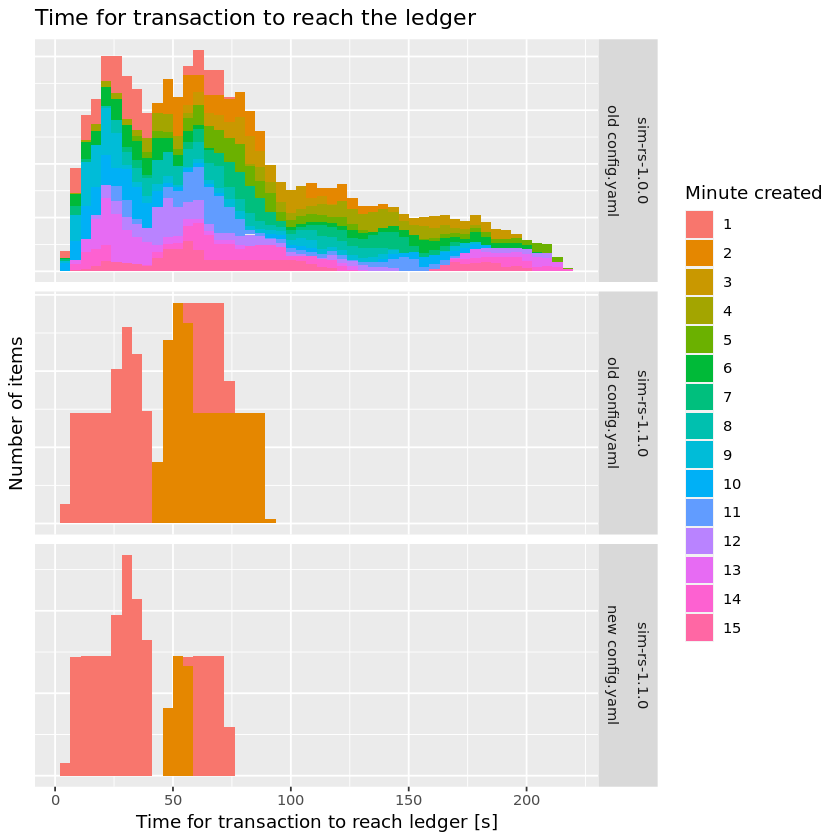

In [27]:
ggplot(
        lifecycle[
            `Kind` == "TX" & 
            !is.na(`To RB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
            .(`sim-cli`, `config.yaml`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
    facet_grid(`sim-cli` + `config.yaml` ~ ., scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [28]:
ggsave("plots/regression-reach-rb-tx.png", units="in", dpi=150, width=16, height=8)

In [29]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [30]:
outcomes <- lifecycle[
    `Kind` == "TX" & `Created [s]` < txLast,
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ),
    .(`sim-cli`, `config.yaml`)
]

In [31]:
totals <- 
    outcomes[
        , 
        .(
            `Total`=.N, 
            `Lost`=sum(is.na(`Time to reach ledger [s]`)),
            `1st min`=sum(`Time to reach ledger [s]`<=60,na.rm=TRUE),
            `2nd min`=sum(`Time to reach ledger [s]`>60&`Time to reach ledger [s]`<=120,na.rm=TRUE),
            `3rd min`=sum(`Time to reach ledger [s]`>120&`Time to reach ledger [s]`<=180,na.rm=TRUE)
        ), 
        .(`sim-cli`, `config.yaml`, `Submitted [minute]`)
    ]

#### Transactions reaching the ledger

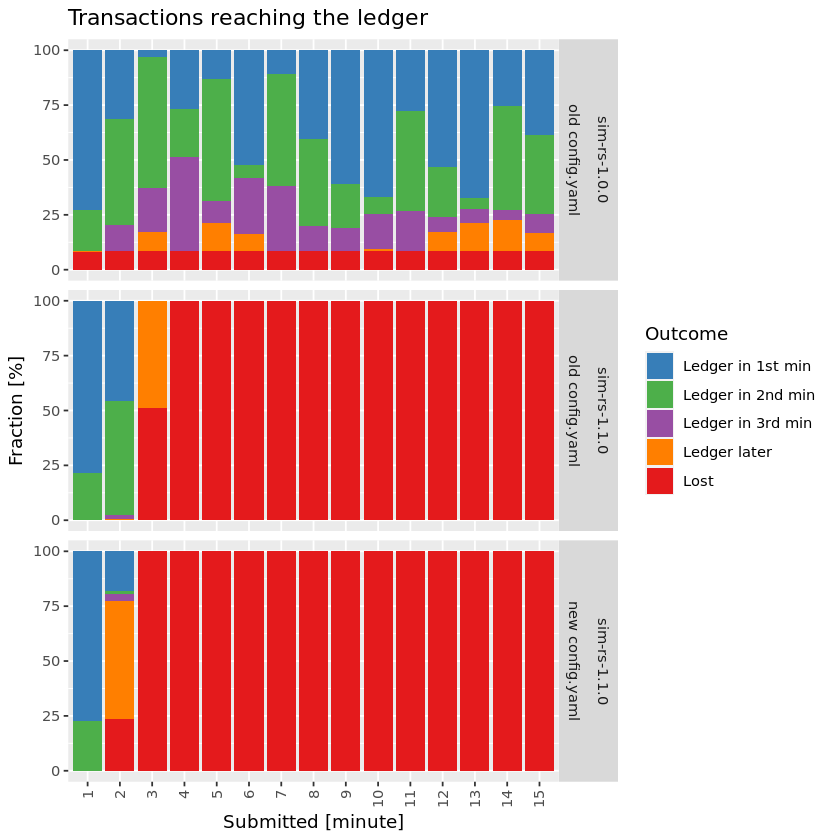

In [32]:
ggplot(
        melt(
            totals[
                , 
                .(
                    `Ledger in 1st min`=`1st min`/`Total`, 
                    `Ledger in 2nd min`=`2nd min`/`Total`, 
                    `Ledger in 3rd min`=`3rd min`/`Total`, 
                    `Ledger later`=(`Total`-`Lost`-`1st min`-`2nd min`-`3rd min`)/`Total`,
                    `Lost`=`Lost`/`Total`
                ), 
                .(`sim-cli`, `config.yaml`, `Submitted [minute]`)
            ],
            id.vars=c("sim-cli", "config.yaml", "Submitted [minute]"),
            variable.name="Outcome",
            value.name="Fraction"
        )[, .(
            `sim-cli`, `config.yaml`,
            `Submitted [minute]`, 
            `Outcome`=factor(`Outcome`,levels=c("Ledger in 1st min", "Ledger in 2nd min", "Ledger in 3rd min", "Ledger later","Lost")), 
            `Fraction [%]`=100*`Fraction`
        )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`sim-cli` + `config.yaml` ~ .) +
    scale_fill_manual(values=c(
        "Ledger in 1st min"=brewer.pal(n=5, name="Set1")[[2]], 
        "Ledger in 2nd min"=brewer.pal(n=5, name="Set1")[[3]], 
        "Ledger in 3rd min"=brewer.pal(n=5, name="Set1")[[4]], 
        "Ledger later"=brewer.pal(n=5, name="Set1")[[5]],
        "Lost"=brewer.pal(n=5, name="Set1")[[1]]
    )) +
    ggtitle("Transactions reaching the ledger") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [33]:
ggsave("plots/regression-temporal-efficiency-bar.png", units="in", dpi=150, width=16, height=8)